# Task for Today  

***

## Blood Cell Type Prediction

We used a TensorFlow pretrained CNN model to make our predictions.

In [12]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [13]:
train_dir = '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
test_dir = '../input/blood-cells/dataset2-master/dataset2-master/images/TEST'

# Loading Image Data

In [14]:
# Generators

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [15]:
# Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


# Build Pretrained Model

In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# Build Classification Model

In [17]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

# Training

In [26]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
249/249 [==============================] - 28s 113ms/step - loss: 0.1039 - accuracy: 0.9684 - val_loss: 0.2100 - val_accuracy: 0.9196
Epoch 2/100
249/249 [==============================] - 28s 113ms/step - loss: 0.0740 - accuracy: 0.9773 - val_loss: 0.2218 - val_accuracy: 0.9145
Epoch 3/100
249/249 [==============================] - 27s 110ms/step - loss: 0.0632 - accuracy: 0.9819 - val_loss: 0.2804 - val_accuracy: 0.9020
Epoch 4/100
249/249 [==============================] - 26s 106ms/step - loss: 0.0625 - accuracy: 0.9813 - val_loss: 0.2472 - val_accuracy: 0.9140
Epoch 5/100
249/249 [==============================] - 26s 105ms/step - loss: 0.0405 - accuracy: 0.9901 - val_loss: 0.1881 - val_accuracy: 0.9341
Epoch 6/100
249/249 [==============================] - 27s 110ms/step - loss: 0.0265 - accuracy: 0.9944 - val_loss: 0.1895 - val_accuracy: 0.9326
Epoch 7/100
249/249 [==============================] - 27s 108ms/step - loss: 0.0240 - accuracy: 0.9957 - val_loss: 0.1998 -

In [19]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

# Results

In [23]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

Test Accuracy: 51.347%


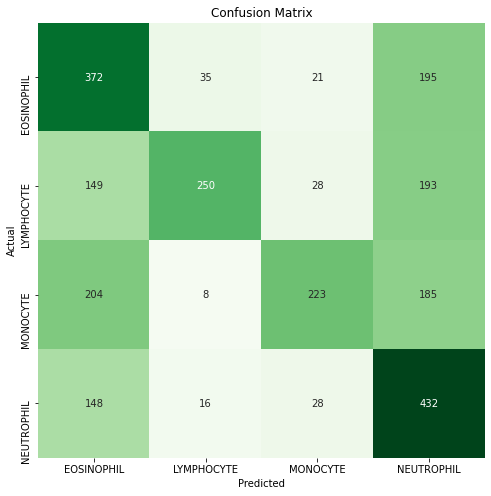

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.43      0.60      0.50       623
  LYMPHOCYTE       0.81      0.40      0.54       620
    MONOCYTE       0.74      0.36      0.48       620
  NEUTROPHIL       0.43      0.69      0.53       624

    accuracy                           0.51      2487
   macro avg       0.60      0.51      0.51      2487
weighted avg       0.60      0.51      0.51      2487



In [24]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Found 1989 images belonging to 4 classes.
Validation Accuracy: 92.408%


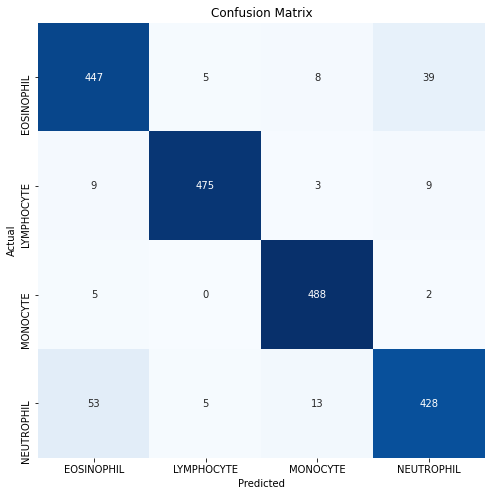

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.87      0.90      0.88       499
  LYMPHOCYTE       0.98      0.96      0.97       496
    MONOCYTE       0.95      0.99      0.97       495
  NEUTROPHIL       0.90      0.86      0.88       499

    accuracy                           0.92      1989
   macro avg       0.92      0.92      0.92      1989
weighted avg       0.92      0.92      0.92      1989



In [25]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


predictions = np.argmax(model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)